In [ ]:
'''DBDM 2017 - Final Problem Set Solution
2. Photometric Redshifts of Galaxies'''

In [181]:
'''Standard packages are loaded'''
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import vstack
from astropy.io.votable import parse
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import binned_statistic
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from matplotlib import pyplot as plt

%matplotlib inline

In [58]:
#Jarles fucntion gots some weird troubles with borders and negative values in y

def running_median(x, y, N = None, binsize = None):
    """Calculate the median in N windows, or windows of size binsize.
    
    This ignores all edge effects - caveat emptor
    """

    if binsize is not None:
        bins = np.arange(0.0, x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(0.0, x.max(), int(N))
        binsize = bins[1]-bins[0]
        
    # This finds the bins that each x should go in.
    # This is convenient for expanding the routine to accept other functions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(int(N))]
    # I also want the x-positions in the bins. I use mean for that
    x_bins = [np.mean(x[idx==k]) for k in range(int(N))]
    
    return np.array(x_bins), np.array(r_med), bins

#I'm trying this one
def Binning(x, y, xmin, xmax, ymin, ymax, N = None):
    
    Nx = np.linspace(xmin, xmax, int(N))
#     Ny = np.linspace(ymin, ymax, int(N-1)) #If y is median
    Ny = np.linspace(ymin, ymax, int(N))
    
    #[0] for Mean, [1] for Median
    bins_1 = binned_statistic(x, x, bins = Nx, range = (xmin, xmax))[0] 
    bins_2 = binned_statistic(y, y, bins = Ny, range = (ymin, ymax))[0] 
                
    return bins_1, bins_2             

In [ ]:
#This is not working with the transpose when stacking the data I need !

# A_Table = Table.read('Q2/Tables/PhotoZFileA.vot', format = 'votable')
# B_Table = Table.read('Q2/Tables/PhotoZFileB.vot', format = 'votable') 

# New_Table = vstack([A_Table, B_Table])
# New_Table

In [27]:
#This is made to correct the problem of vstack and transpose with vot files
#as suggested on various websites

A = parse('Q2/Tables/PhotoZFileA.vot')
B = parse('Q2/Tables/PhotoZFileB.vot')

Table_1 = A.get_first_table()
A_Table = Table_1.to_table().to_pandas()

Table_2 = B.get_first_table()
B_Table = Table_2.to_table().to_pandas()

In [28]:
# Extract some data. I also compute the magnitudes following Connolly et al. (1995a) method
# in order to find the photometric redshift through linear regressions.

Counter = A_Table['Counter']
Mag_r   = A_Table['mag_r']
UG      = A_Table['u-g']
GR      = A_Table['g-r']
RI      = A_Table['r-i']
IZ      = A_Table['i-z']
Z_spec  = A_Table['z_spec']

Mag_g   = Mag_r + GR
Mag_u   = Mag_g + UG
Mag_i   = Mag_r - RI
Mag_z   = Mag_i - IZ

In [29]:
All = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z, Z_spec)).T
Mag = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z)).T

In [70]:
#Fitting - LinearRegression
model_1              = LinearRegression(fit_intercept = True, normalize = True)
res_1                = model_1.fit(Mag, Z_spec)
Z_phot_1             = model_1.predict(Mag)
residuals_1          = Z_phot_1 - Z_spec
relative_residuals_1 = residuals_1/Z_spec

# Note that the intercept for Ridge regression is somewhat hidden..
c_1 = [res_1.intercept_]
[c_1.append(coeff) for coeff in res_1.coef_]

# c_1 = list(res_1.coef_)
# print(len(c_1))
print("Fitting - LinearRegression\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_1[0], c_1[1], c_1[2], c_1[3], c_1[4], c_1[5]))

Discrepancy_1 = np.median( np.abs( (Z_spec - Z_phot_1)/(1.0 + Z_spec) ) )

print("\n The discrepancy is:\n\n   E = %g"%Discrepancy_1)
print("----------------------------------------------------------------------------------------------")

#Fitting - Ridge
model_2              = Ridge(alpha = 0.05, fit_intercept = True, normalize = True)
res_2                = model_2.fit(Mag, Z_spec)
Z_phot_2             = model_2.predict(Mag)
residuals_2          = Z_phot_2 - Z_spec
relative_residuals_2 = residuals_2/Z_spec

# Note that the intercept for Ridge regression is somewhat hidden..
c_2 = [res_2.intercept_]
[c_2.append(coeff) for coeff in res_2.coef_]

print("Fitting - Ridge\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_2[0], c_2[1], c_2[2], c_2[3], c_2[4], c_2[5]))

Discrepancy_2 = np.median( np.abs( (Z_spec - Z_phot_2)/(1.0 + Z_spec) ) )

print("\n The discrepancy is:\n\n   E = %g"%Discrepancy_2)
print("----------------------------------------------------------------------------------------------")

#Fitting - Lasso
model_3              = Lasso(alpha = 0.00001, fit_intercept = True, normalize = True)
res_3                = model_3.fit(Mag, Z_spec)
Z_phot_3             = model_3.predict(Mag)
residuals_3          = Z_phot_3 - Z_spec
relative_residuals_3 = residuals_3/Z_spec

# Note that the intercept for Lasso regression is somewhat hidden..
c_3 = [res_3.intercept_]
[c_3.append(coeff) for coeff in res_3.coef_]

print("Fitting - Lasso\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_3[0], c_3[1], c_3[2], c_3[3], c_3[4], c_3[5]))

Discrepancy_3 = np.median( np.abs( (Z_spec - Z_phot_3)/(1.0 + Z_spec) ) )

print("\n The discrepancy is:\n\n   E = %g"%Discrepancy_3)
print("----------------------------------------------------------------------------------------------")

Fitting - LinearRegression

 The best-fit model is:

   Zphot = -0.783 + -0.013 (mag_u) + 0.096 (mag_g) + 0.372 (mag_r) + -0.395 (mag_i) + -0.021 (mag_z)

 The discrepancy is:

   E = 0.0145589
----------------------------------------------------------------------------------------------
Fitting - Ridge

 The best-fit model is:

   Zphot = -1.248 + 0.009 (mag_u) + 0.052 (mag_g) + 0.033 (mag_r) + -0.003 (mag_i) + -0.013 (mag_z)

 The discrepancy is:

   E = 0.0196486
----------------------------------------------------------------------------------------------
Fitting - Lasso

 The best-fit model is:

   Zphot = -1.200 + 0.000 (mag_u) + 0.076 (mag_g) + 0.000 (mag_r) + 0.000 (mag_i) + 0.000 (mag_z)

 The discrepancy is:

   E = 0.0194353
----------------------------------------------------------------------------------------------


In [10]:
'''LinearRegression always gives the best result in terms of the discrepancy. However, 
Ridge seems to work pretty well, though using values close to zero may in some way 
do the same as LinearRegression. Lasso doesn't work well because one need to set the
alpha parameter to values pretty close to zero where the function may have convergence
issues.
Somehow, I need to find a way to drop the discrepancy to smaller values.'''

"LinearRegression always gives the best result in terms of the discrepancy. However, \nRidge seems to work pretty well, though using values close to zero may in some way \ndo the same as LinearRegression. Lasso doesn't work well because one need to set the\nalpha parameter to values pretty close to zero where the function may have convergence\nissues.\nSomehow, I need to find a way to drop the discrepancy to smaller values."

In [71]:
x_m_LR, med_LR, bins       = running_median(Z_spec, relative_residuals_1, N = 5, binsize = None)
x_m_Ridge, med_Ridge, bins = running_median(Z_spec, relative_residuals_2, N = 5, binsize = 0.15)
x_m_Lasso, med_Lasso, bins = running_median(Z_spec, relative_residuals_3, N = 5, binsize = 0.15)

N = 11
X_bin_1, Y_bin_1       = Binning(Z_spec, relative_residuals_1, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)
X_bin_2, Y_bin_2       = Binning(Z_spec, relative_residuals_2, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)
X_bin_3, Y_bin_3       = Binning(Z_spec, relative_residuals_3, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)

# print(x_m_LR, med_LR)
# print(X_bin, Y_bin[::-1])
print(len(X_bin_1), len(Y_bin_1))
print(X_bin_1, Y_bin_1[::-1])

10 10
[ 0.06660988  0.18142221  0.24333991  0.33584062  0.42218221  0.50546723
  0.59178484  0.70205643  0.80799633  0.8927426 ] [ 0.34371038  0.24222171  0.13979156  0.04337624 -0.04464905 -0.13552454
 -0.2350853  -0.33785396 -0.43885563 -0.53031657]


/usr/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib64/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


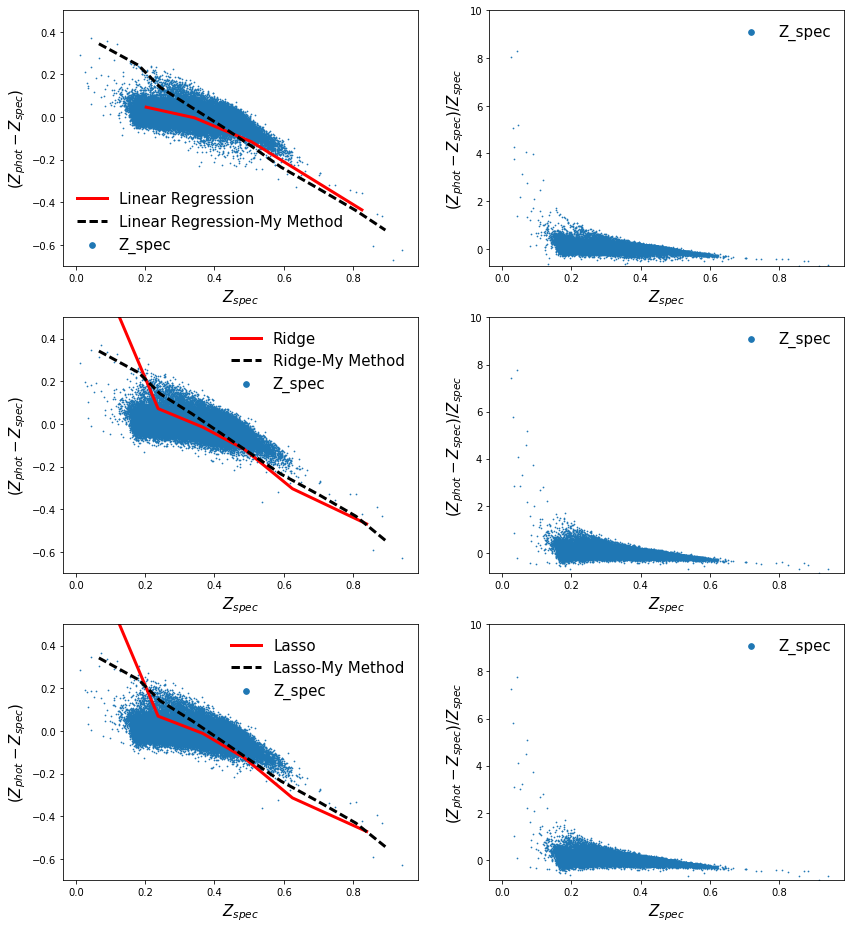

In [72]:
fig, ((axA, axB), (axC, axD), (axE, axF)) = plt.subplots(figsize = (14,16), nrows = 3, ncols = 2)

axA.plot(x_m_LR, med_LR, lw = 3, color = 'red', label = 'Linear Regression')
axA.plot(X_bin_1, Y_bin_1[::-1], '--', lw = 3, color = 'k', label = 'Linear Regression-My Method')
axA.scatter(Z_spec, residuals_1, marker = '.', s = 2, label = 'Z_spec')
axA.set_xlabel(r'$Z_{spec}$', size = 15)
axA.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 15)
axA.set_ylim(-0.7, 0.5)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 8)

axB.scatter(Z_spec, relative_residuals_1, marker = '.', s = 2, label = 'Z_spec')
axB.set_xlabel(r'$Z_{spec}$', size = 15)
axB.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 15)
axB.set_ylim(relative_residuals_1.min(), 10)
axB.legend(frameon = False, prop = {'size': 15}, markerscale = 8);

axC.plot(x_m_Ridge, med_Ridge, lw = 3, color = 'red', label = 'Ridge')
axC.plot(X_bin_2, Y_bin_2[::-1], '--', lw = 3, color = 'k', label = 'Ridge-My Method')
axC.scatter(Z_spec, residuals_2, marker = '.', s = 2, label = 'Z_spec')
axC.set_xlabel(r'$Z_{spec}$', size = 15)
axC.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 15)
axC.set_ylim(-0.7, 0.5)
axC.legend(frameon = False, prop = {'size': 15}, markerscale = 8)

axD.scatter(Z_spec, relative_residuals_2, marker = '.', s = 2, label = 'Z_spec')
axD.set_xlabel(r'$Z_{spec}$', size = 15)
axD.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 15)
axD.set_ylim(relative_residuals_2.min(), 10)
axD.legend(frameon = False, prop = {'size': 15}, markerscale = 8);

axE.plot(x_m_Lasso, med_Lasso, lw = 3, color = 'red', label = 'Lasso')
axE.plot(X_bin_3, Y_bin_3[::-1], '--', lw = 3, color = 'k', label = 'Lasso-My Method')
axE.scatter(Z_spec, residuals_3, marker = '.', s = 2, label = 'Z_spec')
axE.set_xlabel(r'$Z_{spec}$', size = 15)
axE.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 15)
axE.set_ylim(-0.7, 0.5)
axE.legend(frameon = False, prop = {'size': 15}, markerscale = 8)

axF.scatter(Z_spec, relative_residuals_3, marker = '.', s = 2, label = 'Z_spec')
axF.set_xlabel(r'$Z_{spec}$', size = 15)
axF.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 15)
axF.set_ylim(relative_residuals_3.min(), 10)
axF.legend(frameon = False, prop = {'size': 15}, markerscale = 8);

In [ ]:
'''Although Lasso seems to have the best Discrepancy compared to Ridge, Linear Regression
keeps on being the best option. Also because the last one fits all the parameters
needed to compute the photometric redshift. This error is not a reliable estimate
of the general error '''

In [142]:
#this for part C, using B data to find the generalization error 

In [176]:
# Extract some data. I also compute the magnitudes following Connolly et al. (1995a) method
# in order to find the photometric redshift through linear regressions.

Counter = B_Table['Counter']
Mag_r   = B_Table['mag_r']
UG      = B_Table['u-g']
GR      = B_Table['g-r']
RI      = B_Table['r-i']
IZ      = B_Table['i-z']
Z_spec  = B_Table['z_spec']

Mag_g   = Mag_r + GR
Mag_u   = Mag_g + UG
Mag_i   = Mag_r - RI
Mag_z   = Mag_i - IZ

All_B = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z, Z_spec)).T
Mag_B = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z)).T

Score Linear Regression: 0.818649230236
Score Ridge: 0.74737816823
Score Lasso: 0.748568869829


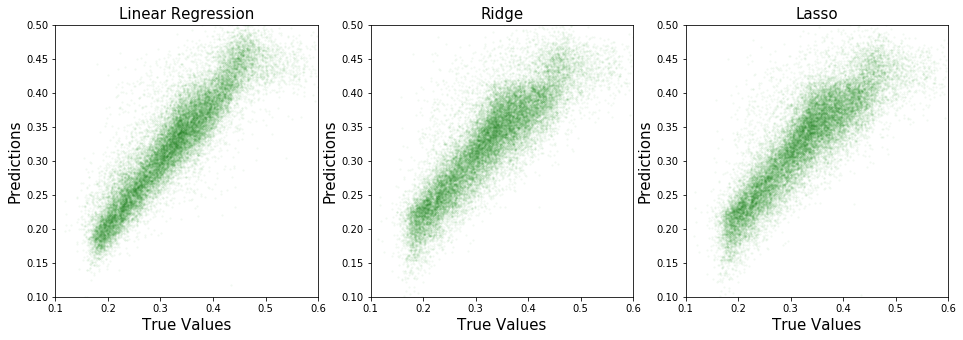

In [202]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(Mag_B, Z_spec, test_size = 0.3)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

lR          = LinearRegression(fit_intercept = True, normalize = True)
Ridge       = Ridge(alpha = 0.05, fit_intercept = True, normalize = True)
Lasso       = Lasso(alpha = 0.00001, fit_intercept = True, normalize = True)

model_1       = lR.fit(X_train, y_train)
predictions_1 = lR.predict(X_test)

model_2       = Ridge.fit(X_train, y_train)
predictions_2 = Ridge.predict(X_test)

model_3       = Lasso.fit(X_train, y_train)
predictions_3 = Lasso.predict(X_test)

# predictions_1[0:5]
# predictions_2[0:5]
# predictions_3[0:5]

## The line / model
fig, ((axA, axB, axC)) = plt.subplots(figsize = (16,5), nrows = 1, ncols = 3)

axA.scatter(y_test, predictions_1, s = 2.5, alpha = 0.03, c = 'g')
axA.set_xlabel("True Values", size = 15)
axA.set_ylabel("Predictions", size = 15)
axA.set_ylim(0.1, 0.5)
axA.set_xlim(0.1, 0.6)
axA.set_title("Linear Regression", size = 15)

axB.scatter(y_test, predictions_2, s = 2.5, alpha = 0.03, c = 'g')
axB.set_xlabel("True Values", size = 15)
axB.set_ylabel("Predictions", size = 15)
axB.set_ylim(0.1, 0.5)
axB.set_xlim(0.1, 0.6)
axB.set_title("Ridge", size = 15)

axC.scatter(y_test, predictions_3, s = 2.5, alpha = 0.03, c = 'g')
axC.set_xlabel("True Values", size = 15)
axC.set_ylabel("Predictions", size = 15)
axC.set_ylim(0.1, 0.5)
axC.set_xlim(0.1, 0.6)
axC.set_title("Lasso", size = 15)

#This tells us how accurate is the model (R^2 =  1 - u/v)
#where u = Residual sum of squares and v = Total sum of squares
print("Score Linear Regression:", model_1.score(X_test, y_test))
print("Score Ridge:", model_2.score(X_test, y_test))
print("Score Lasso:", model_3.score(X_test, y_test))

Cross-validated scores Linear Regression: [ 0.81289381  0.82069431  0.81305674]
Cross-validated scores Ridge: [ 0.72591032  0.74844544  0.75902588]
Cross-validated scores Lasso: [ 0.72955563  0.75002057  0.75836966]

Cross-Predicted Accuracy: 0.815630708276
Cross-Predicted Accuracy: 0.744377677221
Cross-Predicted Accuracy: 0.745922682724


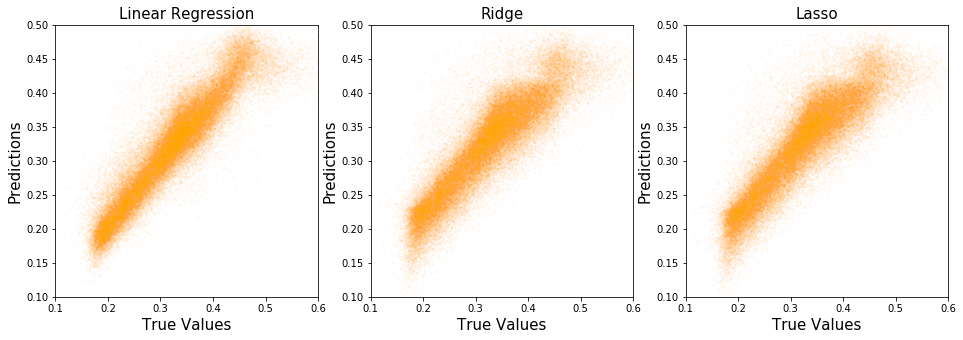

In [196]:
scores_1 = cross_val_score(model_1, Mag_B, Z_spec, cv = 3)
scores_2 = cross_val_score(model_2, Mag_B, Z_spec, cv = 3)
scores_3 = cross_val_score(model_3, Mag_B, Z_spec, cv = 3)

predictions_1 = cross_val_predict(model_1, Mag_B, Z_spec, cv = 3)
predictions_2 = cross_val_predict(model_2, Mag_B, Z_spec, cv = 3)
predictions_3 = cross_val_predict(model_3, Mag_B, Z_spec, cv = 3)

accuracy_1 = metrics.r2_score(Z_spec, predictions_1)
accuracy_2 = metrics.r2_score(Z_spec, predictions_2)
accuracy_3 = metrics.r2_score(Z_spec, predictions_3)

fig, ((axA, axB, axC)) = plt.subplots(figsize = (16,5), nrows = 1, ncols = 3)

axA.scatter(Z_spec, predictions_1, s = 1, alpha = 0.03, c = 'orange')
axA.set_xlabel("True Values", size = 15)
axA.set_ylabel("Predictions", size = 15)
axA.set_ylim(0.1, 0.5)
axA.set_xlim(0.1, 0.6)
axA.set_title("Linear Regression", size = 15)

axB.scatter(Z_spec, predictions_2, s = 1, alpha = 0.03, c = 'orange')
axB.set_xlabel("True Values", size = 15)
axB.set_ylabel("Predictions", size = 15)
axB.set_ylim(0.1, 0.5)
axB.set_xlim(0.1, 0.6)
axB.set_title("Ridge", size = 15)

axC.scatter(Z_spec, predictions_3, s = 1, alpha = 0.03, c = 'orange')
axC.set_xlabel("True Values", size = 15)
axC.set_ylabel("Predictions", size = 15)
axC.set_ylim(0.1, 0.5)
axC.set_xlim(0.1, 0.6)
axC.set_title("Lasso", size = 15)

#The last value here shows how good the training gets after several foldings (cv = 3)
print("Cross-validated scores Linear Regression:", scores_1)
print("Cross-validated scores Ridge:", scores_2)
print("Cross-validated scores Lasso:", scores_3)

#This tells us how accurate is the model (R^2 =  1 - u/v)
#where u = Residual sum of squares and v = Total sum of squares
print("\nCross-Predicted Accuracy:", accuracy_1)
print("Cross-Predicted Accuracy:", accuracy_2)
print("Cross-Predicted Accuracy:", accuracy_3)

In [204]:
#d) Implementation of a Z_phot estimator using k-nearest neighbors
#Lecture 6
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [244]:
#print(Mag_B[:,2:4].shape)

#gp = GaussianProcessRegressor(kernel = RBF(0.1), alpha = 1e-10)
#g = gp.fit(Mag_B[:,2:4], Z_spec)
# y_pred, sigma = gp.predict(xplot[:, np.newaxis], return_std = True)
# plot_a_fit(Mag_B, Z_spec, dy, xplot, y_pred, sigma, include_true = True)

(74557, 2)


MemoryError: 